# **Import Libraries**

---



In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.6.0


# **Import Dataset**

---




In [2]:
!gdown --id '1OOft6zOd2t2A1NWTYkpq-6MyC5ySswl2'

Downloading...
From: https://drive.google.com/uc?id=1OOft6zOd2t2A1NWTYkpq-6MyC5ySswl2
To: /content/UCIHAR.zip
24.3MB [00:00, 47.2MB/s]


In [3]:
!unzip '/content/UCIHAR.zip'

Archive:  /content/UCIHAR.zip
   creating: UCIHAR/
  inflating: UCIHAR/X_test.npy       
  inflating: UCIHAR/X_train.npy      
  inflating: UCIHAR/y_test.npy       
  inflating: UCIHAR/y_train.npy      


In [4]:
!rm '/content/UCIHAR.zip'

In [5]:
## In this dataset Each person performed six activities, while
## wearing a smartphone (Samsung Galaxy S II) on the waist.
dataset_name = "UCIHAR" 
data_class_names = ["Walking", "Stairs-Up", "Stairs-Down", "Sitting", "Standing", "Lying"]

## Here we chose the first 6 sensor streams that shows "accelerometer (x,y,z)"  and "gyroscope (x,y,z)". 
## The remaing 3 streams show the estimated body acceleration which is a dervied data

dataset_address = "/content/UCIHAR/"
X_train = np.load(dataset_address + "X_train.npy")[:,:,:6]
Y_train = np.load(dataset_address + "y_train.npy").argmax(1)
X_test = np.load(dataset_address + "X_test.npy")[:,:,:6]
Y_test = np.load(dataset_address + "y_test.npy").argmax(1)

## Shufflig the training set
rnd_seed = 0
tf.random.set_seed(rnd_seed)
indices = np.random.RandomState(seed=rnd_seed).permutation(len(X_train))
X_train = X_train[indices]
Y_train = Y_train[indices]

## Computing the class weight for each label (in case that dataset is not balanced)
data_class_weights = class_weight.compute_class_weight('balanced',range(len(data_class_names)),Y_train)
data_class_weights = dict(zip(range(len(data_class_weights)),data_class_weights.round(2)))

print("- Data Shape:\n -- Training:  Data {} Labels {} \n -- Testing: Data {} Labels {}".
      format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))
print("- Activity Weights",dict(zip(data_class_names,data_class_weights.values())))

- Data Shape:
 -- Training:  Data (7352, 128, 6) Labels (7352,) 
 -- Testing: Data (2947, 128, 6) Labels (2947,)
- Activity Weights {'Walking': 1.0, 'Stairs-Up': 1.14, 'Stairs-Down': 1.24, 'Sitting': 0.95, 'Standing': 0.89, 'Lying': 0.87}


# **Visualization**

---


Let us plot some of this time windows to get an idea about the data.

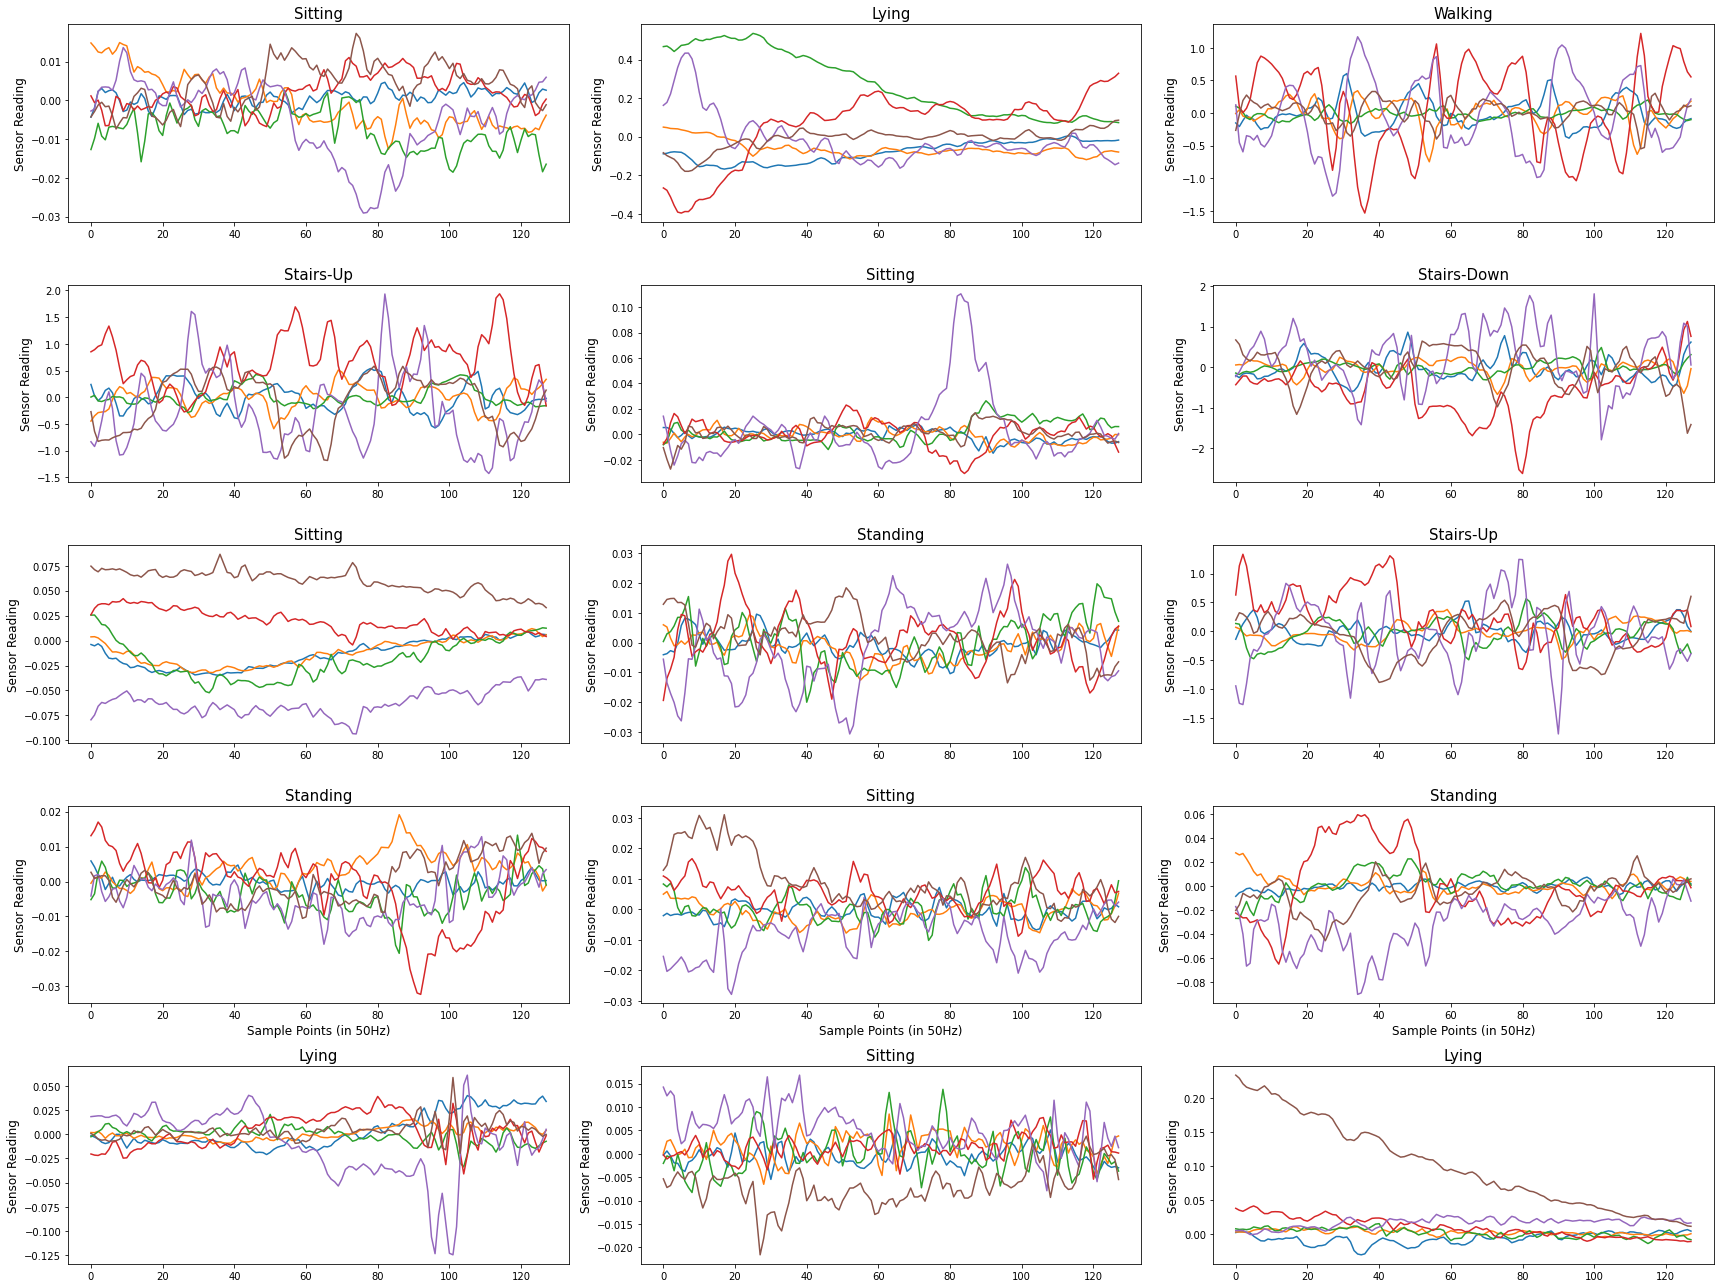

In [6]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(24,18))
for r in range(5):
    for c in range(3):        
        ind = np.random.choice(len(X_train))
        ax[r,c].plot(X_train[ind])
        ax[r,c].set_title(data_class_names[Y_train[ind]], size=15)
        if r == 3:
            ax[r,c].set_xlabel("Sample Points (in 50Hz)", size=12)
        ax[r,c].set_ylabel("Sensor Reading", size=12)
fig.tight_layout()

# **The ConvLSTMCombined Model**

---



In [7]:
def ConvLSTMCombined(inp_shape, out_shape): 
    nb_filters = 64 
    drp_out_dns = .5 
    nb_dense = 128 
    
    inp = Input(inp_shape)

    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='valid', activation='relu')(inp)    
    x = Conv2D(nb_filters, kernel_size = (5,1),
              strides=(1,1), padding='valid', activation='relu')(x)
    x = Conv2D(nb_filters, kernel_size = (5,1), 
              strides=(1,1), padding='valid', activation='relu')(x)
    x = Conv2D(nb_filters, kernel_size = (5,1), 
              strides=(1,1), padding='valid', activation='relu')(x)    
    x = Reshape((x.shape[1],x.shape[2]*x.shape[3]))(x)
    act = LSTM(nb_dense, return_sequences=True, activation='tanh', name="lstm_1")(x)        
    act = Dropout(drp_out_dns, name= "dot_1")(act)
    act = LSTM(nb_dense, return_sequences=True, activation='tanh', name="lstm_2")(act)        
    act = Dropout(drp_out_dns, name= "dot_2")(act)
    act = LSTM(nb_dense, activation='tanh', name="lstm_3")(act)        
    act = Dropout(drp_out_dns, name= "dot_3")(act)
    out_act = Dense(out_shape, activation='softmax',  name="act_smx")(act)
    
    model = keras.models.Model(inputs=inp, outputs=out_act)
    model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
    return model

In [8]:
num_epochs = 100
# print(X_train.shape)
# print(X_test.shape)
X_train = np.expand_dims(X_train,3)
X_test = np.expand_dims(X_test,3)
# print(X_train.shape)
# print(X_test.shape)
w = X_train.shape[1]
h = X_train.shape[2]
# print(w)
# print(h)
# print(X_train[len(X_train)//10:].shape)
model = ConvLSTMCombined((w, h, 1), len(np.unique(Y_train)))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 6, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 6, 64)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 6, 64)        20544     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 6, 64)        20544     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 6, 64)        20544     
_________________________________________________________________
reshape (Reshape)            (None, 112, 384)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 112, 128)          262656

In [9]:
def Model_Train(model, X_train, Y_train, X_val, Y_val, data_class_weights,
                      batch_size=128, num_epochs=128, save_dir=None):
  
    val_acc = []
    loss = []
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()
    best_val_accuracy = 0.
    for epoch in range(num_epochs):  

        ## Training
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = iter(train_dataset.shuffle(len(X_train)).batch(batch_size))
        n_iterations_per_epoch = len(X_train)//(batch_size)
        epoch_loss_avg = tf.keras.metrics.Mean()           
        for i in range(n_iterations_per_epoch):                
            with tf.GradientTape() as tape:
                X, Y = next(train_dataset)
                sample_weight = [data_class_weights[y] for y in Y.numpy()]                        
                logits = model(X)               
                loss_value = loss_fn(Y, logits, sample_weight)
            gradients = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))                        
            epoch_loss_avg.update_state(loss_value)

        ## Validation
        val_accuracy = tf.keras.metrics.Accuracy()
        logits = model(X_val, training=False)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        val_accuracy(prediction, Y_val)
        current_val_acc = val_accuracy.result()
        
        if current_val_acc > best_val_accuracy:
            best_val_accuracy = current_val_acc
            if save_dir:
                model.save_weights(save_dir)
                
        print ("Epoch {} -- Training Loss = {:.4f} -- Validation Accuracy {:.4f}".format(
            epoch,
            epoch_loss_avg.result(),
            current_val_acc))
        val_acc.append(current_val_acc)
        loss.append(epoch_loss_avg.result())
    
    
    if save_dir:
        model.load_weights(save_dir)
    print("Best Validation Accuracy {:.4f}".format(best_val_accuracy))
    print("Training Finished! \n------------------\n")
    return model,val_acc,loss

In [10]:
model,val_acc,loss = Model_Train(model, 
                              X_train[len(X_train)//10:], Y_train[len(X_train)//10:],
                              X_train[:len(X_train)//10], Y_train[:len(X_train)//10],
                              data_class_weights,
                              batch_size=64, num_epochs=num_epochs,
                              save_dir = "saved_models/ConvLSTMCombined/model_" + str(num_epochs))

Epoch 0 -- Training Loss = 1.1222 -- Validation Accuracy 0.5211
Epoch 1 -- Training Loss = 0.8745 -- Validation Accuracy 0.5918
Epoch 2 -- Training Loss = 0.7313 -- Validation Accuracy 0.6014
Epoch 3 -- Training Loss = 0.7951 -- Validation Accuracy 0.5755
Epoch 4 -- Training Loss = 0.6358 -- Validation Accuracy 0.5850
Epoch 5 -- Training Loss = 0.5879 -- Validation Accuracy 0.6177
Epoch 6 -- Training Loss = 0.5688 -- Validation Accuracy 0.6150
Epoch 7 -- Training Loss = 0.5786 -- Validation Accuracy 0.6204
Epoch 8 -- Training Loss = 0.5593 -- Validation Accuracy 0.6245
Epoch 9 -- Training Loss = 0.5601 -- Validation Accuracy 0.6259
Epoch 10 -- Training Loss = 0.5597 -- Validation Accuracy 0.6231
Epoch 11 -- Training Loss = 0.5522 -- Validation Accuracy 0.6286
Epoch 12 -- Training Loss = 0.5485 -- Validation Accuracy 0.6327
Epoch 13 -- Training Loss = 0.6125 -- Validation Accuracy 0.6190
Epoch 14 -- Training Loss = 0.5582 -- Validation Accuracy 0.6204
Epoch 15 -- Training Loss = 0.5549 

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(x, y):
    plt.plot(x)
    plt.plot(y)
    plt.xlabel("Epochs")
    plt.ylabel("accuracy VS loss")
    plt.legend(['validation_accuracy', 'training_loss'])
    plt.show()

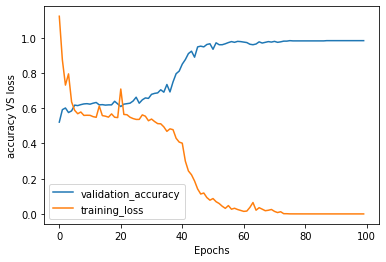

In [12]:
plot_graphs(val_acc,loss)

### Test Accuracy for standard Model

In [13]:
## Testing
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(X_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, Y_test)
print("Test Accuracy {:.4f}".format(test_accuracy.result()))

Test Accuracy 0.9243


In [14]:
cr = classification_report(Y_test, prediction)
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       496
           1       0.96      0.90      0.93       471
           2       0.97      0.96      0.97       420
           3       0.87      0.92      0.90       491
           4       0.88      0.95      0.91       532
           5       0.91      0.84      0.88       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.92      0.92      2947



In [15]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [16]:
plot_classification_report(cr)
plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
plt.close()

[0.98, 0.98, 0.98]
[0.96, 0.9, 0.93]
[0.97, 0.96, 0.97]
[0.87, 0.92, 0.9]
[0.88, 0.95, 0.91]
[0.91, 0.84, 0.88]
plotMat: [[0.98, 0.98, 0.98], [0.96, 0.9, 0.93], [0.97, 0.96, 0.97], [0.87, 0.92, 0.9], [0.88, 0.95, 0.91], [0.91, 0.84, 0.88]]
support: [496, 471, 420, 491, 532, 537]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


# **Confusion Matrix**

---



In [17]:
lbls = ["Walking", "Stairs-Up", "Stairs-Down", "Sitting", "Standing", "Lying"]
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize = (12,8))
    ax.grid(False)
    im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Oranges)
    ax.figure.colorbar(im, ax = ax)
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xticklabels([''] + lbls)
    ax.set_yticklabels([''] + lbls)
    plt.xticks(rotation=90)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i,j]), ha = "center", va = "center", color = "white" if cm[i,j]> thresh else "black", fontsize=16)
            fig.tight_layout()

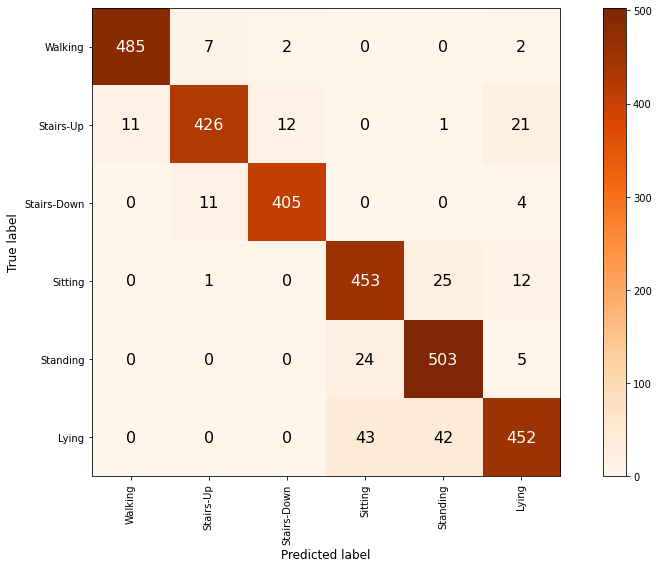

In [18]:
# Plot confusion Matrix
cm = confusion_matrix(Y_test, prediction)
plot_confusion_matrix(cm)